<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 4 / SPRINT 2 / NOTE 2*

---

# 단어를 분산 표현(Distributed Representation)으로 나타내기

## 1. Distributed Representation

지난 시간에는 문서 내에 단어가 등장하는 횟수를 기반으로 문서를 벡터화하는 **등장 횟수 기반 표현(Count-based Representation)**에 대해서 알아보았습니다.



이번 시간에는 단어 자체를 벡터화하는 방법에 대해서 알아보겠습니다.<br/>
아래에 등장하는 Word2Vec 에서는 우리가 벡터화하고자 하는 **타겟 단어(Target word)의 표현이 해당 단어 주변 단어에 의해 결정**됩니다.

단어 벡터를 이렇게 정하는 이유는 [분포 가설(Distribution hypothesis)](https://en.wikipedia.org/wiki/Distributional_semantics) 때문입니다.<br/>
분포 가설은 다음과 같습니다.

> **'비슷한 위치에서 등장하는 단어들은 비슷한 의미를 가진다'**

<img src="http://cdn.ppomppu.co.kr/zboard/data3/2018/1004/m_1538578985_9861_3dba059e_23ec_43dc_9f27_ce1d58c00e71.png.jpg">

'유유상종'이라는 사자성어처럼 **비슷한 의미를 지닌 단어는 주변 단어 분포도 비슷하다**는 것이죠.

예를 들어, 아래와 같은 두 문장이 있다고 해보겠습니다.

- I found **good** stores.
- I found **beautiful** stores.

두 문장에서 _"**good** 과 **beautiful** 은 해당 단어 주변에 분포한 단어가 유사하기 때문에 비슷한 의미를 지닐 것이다"_ 라고 가정하는 것이 분포 가설입니다.

바로 이 분포 가설에 기반하여 주변 단어 분포를 기준으로 단어의 벡터 표현이 결정되기 때문에 **<font color="ff6f61">분산 표현(Distributed representation)</font>**이라고 부르게 됩니다.

본격적으로 분산 표현을 배우기에 앞서, **원-핫 인코딩(One-hot Encoding)**에 대해 알아보겠습니다.

### 1) 원-핫 인코딩(One-hot Encoding)

원-핫 인코딩은 범주형 변수(Categorical feature)를 벡터로 나타내는 방법 중 하나인데요.<br/>
이런 특성을 살려 단어를 벡터화하고자 할 때에도 사용할 수 있습니다.

데이터프레임에서 범주형 변수를 요소마다 [0 0 0 1 ...] 의 형태로 나타냈던 것과 동일한 방법을 사용합니다.

> "I am a student"

라는 문장에서 각 단어를 원-핫 인코딩으로 나타내면 다음과 같습니다.

> I : [1 0 0 0] <br/>
> am : [0 1 0 0] <br/>
> a : [0 0 1 0] <br/>
> student : [0 0 0 1]

In [ ]:
sent = "I am a student"
word_lst = sent.split() # ['I', 'am', 'a', 'student']

word_dict = {} # 딕셔너리 형태로 담을거양!

for idx, word in enumerate(word_lst): #idx = index값 
    vec = [0 for _ in range(len(word_lst))]  #변수지정없이 4번 반복한다 #range(0부터 4) #0으로 채워준다
    vec[idx] = 1
    word_dict[word] = vec

print(word_dict)

{'I': [1, 0, 0, 0], 'am': [0, 1, 0, 0], 'a': [0, 0, 1, 0], 'student': [0, 0, 0, 1]}


In [ ]:
#for문 과정
# vec = [0,0,0,0]
# vec[0] = [1, 0, 0, 0]
# word_dict[i] = [1, 0, 0, 0]

쉽게 이해할 수 있는 직관적인 방법이지만 원-핫 인코딩에는 치명적인 단점이 있습니다.<br/>
바로 단어 간 유사도를 구할 수 없다는 점인데요.

단어 간 유사도를 구할 때에는 **코사인 유사도(cosine similarity)**가 자주 사용됩니다.<br/>
코사인 유사도를 구하기 위한 식은 다음과 같습니다.

$$
\large \text{Cosine similarity} = \frac{\vec{a} \cdot \vec{b} }{\vert \vec{a} \vert \vert \vec{b} \vert }
$$

원-핫 인코딩을 적용한 서로 다른 두 벡터의 내적은 항상 0이므로, 어떤 두 단어를 골라 코사인 유사도를 구하더라도 그 값은 0이 됩니다.<br/>
이렇게 두 단어 사이의 관계를 전혀 알 수 없다는 것이 원-핫 인코딩의 최대 단점입니다.

In [ ]:
import numpy as np

def cos_sim(a, b):
    """
    코사인 유사도를 구하는 함수입니다.
    
    Args:
        a, b : 토큰 벡터입니다 -> array
    """
    arr_a = np.array(a)
    arr_b = np.array(b)

    result = np.dot(arr_a, arr_b)/(np.linalg.norm(arr_a)*np.linalg.norm(arr_b))
    return result

print(f"I 와 am 의 코사인 유사도 : {cos_sim(word_dict['I'], word_dict['am'])}")
print(f"I 와 student 의 코사인 유사도 : {cos_sim(word_dict['I'], word_dict['student'])}")

I 와 am 의 코사인 유사도 : 0.0
I 와 student 의 코사인 유사도 : 0.0


### 2) 임베딩(Embedding)

원-핫 인코딩의 단점을 해결하기 위해 등장한 것이 **<font color="ff6f61">임베딩(Embedding)</font>**입니다. <br/>
단어를 고정 길이의 벡터, 즉 차원이 일정한 벡터로 나타내기 때문에 '임베딩'이라는 이름이 붙었습니다.<br/>
**임베딩을 거친 단어 벡터는 원-핫 인코딩과는 다른 형태의 값을 가집니다.**

예를 들어,

> [0.04227, -0.0033, 0.1607, -0.0236, ...]

위와 같이 벡터 내의 각 요소가 연속적인 값을 가지게 됩니다.<br/>
어떻게 이런 벡터가 만들어지는지, 가장 널리 알려진 임베딩 방법인 **`Word2Vec`** 를 통해 알아보도록 하겠습니다.

> ❗️ *임베딩의 개념, 즉 '벡터가 아닌 것을 고정 길이의 벡터로 나타내기'는 자연어처리 외 다른 딥러닝 분야에서도 등장하니 잘 기억해두도록 합시다. :)*

## 2. Word2Vec

2013년에 고안된 **<font color="ff6f61">Word2Vec</font>** 은 말 그대로 **단어를 벡터로(Word to Vector) 나타내는 방법**으로 가장 널리 사용되는 임베딩 방법 중 하나입니다.<br>
**`Word2Vec`**은 특정 단어 양 옆에 있는 두 단어(**`window size = 2`**)의 관계를 활용하기 때문에 **분포 가설을 잘 반영**하고 있습니다.

**`Word2Vec`** 에는 **`CBoW`**와 **`Skip-gram`**의 2가지 방법이 있습니다.<br/>
두 가지 방법이 어떻게 다른지에 대해서 알아보도록 하겠습니다.

### 1) CBoW 와 Skip-gram

`CBoW`와 `Skip-gram`의 차이는 

1. 주변 단어에 대한 정보를 기반으로 중심 단어의 정보를 예측하는 모델인지 ▶️ **<font color="ff6f61">CBoW(Continuous Bag-of-Words)</font>**
2. 중심 단어의 정보를 기반으로 주변 단어의 정보를 예측하는 모델인지 ▶️ **<font color="ff6f61">Skip-gram</font>**

에 따라서 달라집니다.

아래 그림을 통해 두 방식의 차이를 좀 더 잘 이해해보도록 하겠습니다.

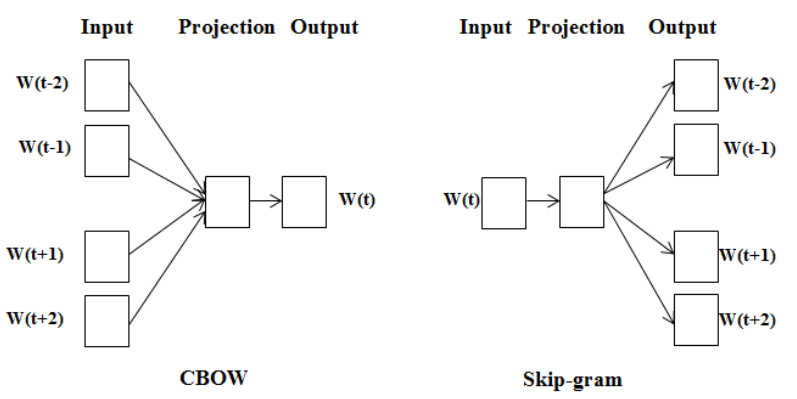

예시를 통해서도 둘의 차이를 알아보겠습니다.<br/>
<별 헤는 밤> 의 일부분에 형태소 분석기를 적용하여 토큰화한 것입니다.

> “… 어머님 나 는 별 하나 에 아름다운 말 한마디 씩 불러 봅니다 …”

**CBoW** 를 사용하면 표시된 단어 정보를 바탕으로 아래의 [ ---- ] 에 들어갈 단어를 예측하는 과정으로 학습이 진행됩니다.

> “… 나 는 [ -- ] 하나 에 … “ <br/>
> “… 는 별 [ ---- ] 에 아름다운 …”<br/>
> “… 별 하나 [ -- ] 아름다운 말 …”<br/>
> “… 하나 에 [ -------- ] 말 한마디 …”

**Skip-gram** 을 사용하면 표시된 단어 정보를 바탕으로 다음의 [ ---- ] 에 들어갈 단어를 예측하는 과정으로 학습이 진행됩니다.

> “… [ -- ] [ -- ] 별 [ ---- ] [ -- ] …” <br/>
> “… [ -- ] [ -- ] 하나 [ -- ] [ -------- ] …” <br/>
> “… [ -- ] [ ---- ] 에 [ -------- ] [ -- ] …” <br/>
> “… [ ---- ] [ -- ] 아름다운 [ -- ] [ ------ ] …”

더 많은 정보를 바탕으로 특정 단어를 예측하기 때문에 CBoW의 성능이 더 좋을 것으로 생각하기 쉽지만,<br/>
역전파 관점에서 보면 Skip-gram에서 훨씬 더 많은 학습이 일어나기 때문에 **Skip-gram의 성능이 조금 더 좋게 나타납니다.**<br/>
물론 계산량이 많기 때문에 Skip-gram에 드는 리소스가 더 큰 것도 사실입니다.

### 2) Word2Vec 모델의 구조

성능 덕분에 조금 더 자주 사용되는 Skip-gram을 기준으로 Word2Vec의 구조에 대해 알아보겠습니다.

- 입력 : Word2Vec의 입력은 원-핫 인코딩된 단어 벡터입니다.
- 은닉층 : 임베딩 벡터의 차원수 만큼의 노드로 구성된 은닉층이 1개인 신경망입니다.
- 출력층 : 단어 개수 만큼의 노드로 이루어져 있으며 활성화 함수로 소프트맥스를 사용합니다.

아래 그림을 통해서 Word2Vec 모델의 개략적인 구조에 대해 알아보겠습니다.

논문에서는 총 10,000개의 단어에 대해서 300차원의 임베딩 벡터를 구했기 때문에<br/>
신경망 구조가 아래와 같아졌습니다.

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" width="800" />


### 3) Word2Vec 학습을 위한 학습 데이터 디자인

효율적인 Word2Vec 학습을 위해서는 학습 데이터를 잘 구성해야 합니다.<br/>
Window 사이즈가 2인 Word2Vec 이므로 중심 단어 옆에 있는 2개 단어에 대해 단어쌍을 구성합니다.

예를 들어, **"The tortoise jumped into the lake"** 라는 문장에 대해 단어쌍을 구성해보겠습니다.<br/>
윈도우 크기가 2인 경우 다음과 같이 Skip-gram을 학습하기 위한 데이터 쌍을 구축할 수 있습니다.

- 중심 단어 : **The**, 주변 문맥 단어 : tortoise, jumped
    - 학습 샘플: (the, tortoise), (the, jumped)
- 중심 단어 : **tortoise**, 주변 문맥 단어 : the, jumped, into
    - 학습 샘플: (tortoise, the), (tortoise, jumped), (tortoise, into)
- 중심 단어 : **jumped**, 주변 문맥 단어 : the, tortoise, into, the
    - 학습 샘플: (jumped, the), (jumped, tortoise), (jumped, into), (jumped, the)
- 중심 단어 : **into**, 주변 문맥 단어 : tortoise, jumped, the, lake
    - 학습 샘플: (into, tortoise), (into, jumped), (into, the), (into, lake)

이런 방법으로 학습 데이터를 만들면 다음과 같은 데이터쌍이 만들어 집니다. 

|중심단어|문맥단어|
|---------|---------|
|the|tortoise|
|the|jumped|
|tortoise|the|
|tortoise|jumped|
|tortoise|into|
|jumped|the|
|jumped|tortoise|
|jumped|into|
|jumped|the|
|into|tortoise|
|into|jumped|
|into|the|
|into|lake|
|...|...|

Skip-gram 에서는 중심단어를 입력으로, 문맥단어를 레이블로 하는 분류(Classification)를 통해 학습한다고 생각하시면 되겠습니다.

### 4) Word2Vec의 결과

학습이 모두 끝나면 10000개의 단어에 대해 300차원의 임베딩 벡터가 생성됩니다. <br/>
만약에 임베딩 벡터의 차원을 조절하고 싶다면 은닉층의 노드 수를 줄이거나 늘릴 수 있습니다.<br/>

아래 그림은 신경망 내부에 있는 $10000 \times 300$ 크기의 가중치 행렬에 의해서<br/>
10000개 단어에 대한 300차원의 벡터가 생성되는 모습을 나타낸 이미지입니다.

<img src="https://i.imgur.com/1ETMljf.png" width="600" />


학습과정에서 Word2Vec의 계산량을 줄이기 위해 사용하는 기법들이 있지만 아직은 너무 깊게 들어가지 않겠습니다.<br/>
추후 아래 키워드를 통해 Word2Vec을 조금 더 적은 계산으로 하는 방법에 대해 조사해보시면 좋겠습니다.

- 더 알아보기
    - Sub-sampling
    - Negative-sampling

결과적으로 Skip-gram 모델을 통해 10000개 단어에 대한 임베딩 벡터를 얻을 수 있습니다.<br/>
이렇게 얻은 임베딩 벡터는 문장 간의 관련도 계산, 문서 분류같은 작업에 사용할 수 있습니다.

### 5) Word2Vec으로 임베딩한 벡터 시각화

Word2Vec을 통해 얻은 임베딩 벡터는 **<font color="ff6f61">단어 간의 의미적, 문법적 관계를 잘 나타냅니다.</font>**<br/>
이를 대표적으로 잘 보여주는 것이 아래 그림입니다.<br/>

1. **`man - woman`** 사이의 관계와 **`king - queen`** 사이의 관계가 매우 유사하게 나타납니다.<br/>
생성된 임베딩 벡터가 단어의 **의미적(Semantic) 관계를 잘 표현**하는 것을 확인할 수 있습니다.

2. **`walking - walked`** 사이의 관계와 **`swimming - swam`** 사이의 관계가 매우 유사하게 나타납니다.<br/>
생성된 임베딩 벡터가 단어의 **문법적(혹은 구조적, Syntactic)인 관계도 잘 표현**하는 것을 확인할 수 있습니다.

3. 고유명사에 대해서도 나라 - 수도 와 같은 관계를 잘 나타내고 있는 것을 확인할 수 있습니다.

<img src="https://miro.medium.com/max/3010/1*OEmWDt4eztOcm5pr2QbxfA.png"/>

## 3. gensim 패키지로 word2Vec 실습하기

**`gensim`** 은 **`Word2Vec`** 으로 사전 학습된 임베딩 벡터를 쉽게 사용해볼 수 있는 패키지입니다.<br/>
gensim을 사용하여 word2vec의 결과가 어떻게 도출되는지 알아보겠습니다.

0. **(시작하기 전에) `gensim` 패키지를 최신 버전으로 업그레이드합니다.**

    > ❗️ *아래 `--upgrade` 셀을 실행하여 `gensim` 패키지를 업그레이드 한 후,*  
    > *메뉴 탭에서 "런타임 > 런타임 다시 시작"을 클릭하여 런타임을 재시작 해줍니다.*  
    > *이후 아래 `.__version__` 이 있는 셀을 활용하여 업그레이드가 잘 되었는지 확인합니다.*

In [ ]:
#코랩에서 gensim 업그레이드 해줘야 함
#런타임 초기화 해주기
!pip install gensim --upgrade

In [ ]:
import gensim

gensim.__version__

'4.2.0'

1. **구글 뉴스 말뭉치로 학습된 `word2vec` 벡터를 다운받습니다.** (시간이 오래 걸립니다.)

In [ ]:
#5분에서 10분 정도 걸림 #이미 임베딩이 됨
import gensim.downloader as api

wv = api.load('word2vec-google-news-300') #모델 저장

[=================================================-] 99.6% 1656.1/1662.8MB downloaded


2. **0 ~ 9 인덱스에 위치한 단어가 무엇인지 확인해봅시다.**

In [ ]:
wv.index_to_key

In [ ]:
for idx, word in enumerate(wv.index_to_key):
    if idx == 10:
        break
#인덱스/단어총 개수
    print(f"word #{idx}/{len(wv.index_to_key)} is '{word}'")

word #0/3000000 is '</s>'
word #1/3000000 is 'in'
word #2/3000000 is 'for'
word #3/3000000 is 'that'
word #4/3000000 is 'is'
word #5/3000000 is 'on'
word #6/3000000 is '##'
word #7/3000000 is 'The'
word #8/3000000 is 'with'
word #9/3000000 is 'said'


3. **임베딩 벡터의 차원과 값을 눈으로 확인해봅시다.**

    **"king"** 이라는 단어의 벡터의 shape을 출력하여 임베딩 벡터의 차원을 확인해봅시다.<br/>
결과를 통해 **`Word2Vec`** 을 통해 학습된 임베딩 벡터는 300차원이며, 벡터의 요소가 원-핫 인코딩과는 다르다는 것을 확인할 수 있습니다.

In [ ]:
vec_king = wv['king'] #단어의 벡터

print(f"임베딩 벡터의 차원 수 : {vec_king.shape}\n")
print(f"'king' 의 임베딩 벡터 \n\n {vec_king}")

4. **말뭉치에 등장하지 않는 단어의 임베딩 벡터를 확인해봅시다.**

    **cameroon** 이라는 단어는 사전에 지정해 준 단어 집합(Vocabulary, **`vocab`**)에 등장하지 않는 단어(Unknown token)인데요.<br/>
이 단어를 'King' 같이 임베딩 벡터화 해보면 **`KeyError`** 가 발생합니다.<br/>
이처럼 **`Word2Vec`**은 단어 집합에 지정하지 않은 단어는 벡터화 할 수 없다는 단점이 있습니다.

In [ ]:
#OOV 문제
import gensim
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

sample_kw = 'softmax'
vec_sample_kw = wv[sample_kw]

print(vec_sample_kw)

KeyError: ignored

In [ ]:
#단점 oov문제
unk = 'cameroon'

try:
    vec_unk = wv[unk]
except KeyError:
    print(f"""단어 "{unk}"은 해당 모델에는 등장하지 않는 단어입니다.""")

단어 "cameroon"은 해당 모델에는 등장하지 않는 단어입니다.


5. **단어 간 유사도를 파악해봅시다.**

    **`gensim`** 패키지가 제공하는 **`.similarity`** 를 활용하면 단어 간 유사도를 파악할 수 있습니다.<br/>
원-핫 인코딩과 다르게 임베딩 벡터는 단어 간 유사도를 구했을 때 0 아닌 값이 나오게 됩니다.<br/>
아래는 **'car'** 와 몇몇 단어의 유사도를 비교한 결과입니다.

In [ ]:
pairs = [
    ('car', 'minivan'),   
    ('car', 'bicycle'),  
    ('car', 'airplane'),
    ('car', 'cereal'),    
    ('car', 'democracy')
]

for w1, w2 in pairs:
    print(f'{w1} ======= {w2}\t  {wv.similarity(w1, w2):.2f}')

car ======= minivan	  0.69
car ======= bicycle	  0.54
car ======= airplane	  0.42
car ======= cereal	  0.14
car ======= democracy	  0.08


In [ ]:
pairs = [
    ('car', 'minivan'),   
    ('car', 'bicycle'),  
    ('car', 'airplane'),
    ('car', 'cereal'),    
    ('car', 'democracy')
]
#.2f(float) 자리수
for w1, w2 in pairs:
    print(f'{w1} ======= {w2} {wv.similarity(w1, w2): .2f}')

car ======= minivan  0.69
car ======= bicycle  0.54
car ======= airplane  0.42
car ======= cereal  0.14
car ======= democracy  0.08


**`.most_similar`** 메서드를 사용하여

**`'car'`** 벡터에 **`'minivan'`** 벡터를 더한 벡터와 가장 유사한 5개의 단어를 뽑아보겠습니다.

In [ ]:
for i, (word, similarity) in enumerate(wv.most_similar(positive=['car', 'minivan'], topn=5)):
    print(f"Top {i+1} : {word}, {similarity}")

Top 1 : SUV, 0.8532192707061768
Top 2 : vehicle, 0.8175783753395081
Top 3 : pickup_truck, 0.7763688564300537
Top 4 : Jeep, 0.7567334175109863
Top 5 : Ford_Explorer, 0.7565720081329346


시각화에서 확인한 것처럼 **`king`** 벡터에 **`women`** 벡터를 더한 뒤 **`men`** 벡터를 빼준 벡터와 가장 유사한 벡터로 **`queen`** 이 나오는 것과<br/>
**`walking`** 벡터에 **`swam`** 벡터를 더한 뒤 **`walked`** 벡터를 빼준 벡터와 가장 유사한 벡터로 **`swimming`** 이 나오는 것을 확인할 수 있습니다.

In [ ]:
print(wv.most_similar(positive=['king', 'women'], negative=['men'], topn=1))
print(wv.most_similar(positive=['walking', 'swam'], negative=['walked'], topn=1))

[('queen', 0.6525818109512329)]
[('swimming', 0.7448815703392029)]


`.doesnt_match` 메서드를 사용하여

['fire', 'water', 'land', 'sea', 'air', 'car'] 중에서 가장 관계 없는 단어를 뽑아봅시다.

In [ ]:
print(wv.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car']))

car


## 4. 임베딩 벡터를 사용하여 문장 분류 수행하기

이미 학습된 임베딩 벡터를 사용하여 문장 분류를 수행하는 코드에 대해 알아보겠습니다.<br/>
아래 코드에서는 **문서에 있는 단어 벡터의 평균을 해당 문서의 벡터로 사용**하여 분류 문제를 수행합니다.

예를 들어, "I am a student"라는 문장을 구성하는 단어의 임베딩 벡터가 아래와 같다고 해보겠습니다.
> $\text{I} = [0.0012, 0.0345, ... , -0.0048, -0.0425]$<br/>
> $\text{am} = [0.0232, -0.0141, ... , -0.0542, 0.0454]$<br/>
> $\text{a} = [0.0022, 0.0905, ... , -0.0241, 0.0028]$<br/>
> $\text{student} = [-0.0110, 0.0492, ... , 0.0008, -0.0420]$

이 때, "I  am a student"라는 문장을 분류하기 위해서 최종적으로 아래 벡터를 사용합니다.

> $[0.0039, 0.0400, ... , -0.0206, -0.0091]$

이게 되나 싶을 정도로 간단하지만, 간단한 문서 분류 문제에서는 꽤 좋은 성능을 보이기 때문에 Baseline 모델로 많이 사용됩니다.

In [ ]:
#임베딩한 값을 다 더해서 평균을 내줌

1. **필요한 모듈을 `import` 해줍니다.**

In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.datasets import imdb

2. **Seed를 정해줍니다.**

In [ ]:
tf.random.set_seed(42)

3. **데이터셋을 split 해줍니다.**

In [ ]:
#(num_words=20000가장 빈도가 높은단어
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=20000)

In [ ]:
print(f"Train set shape : {X_train.shape}")
print(f"Test set shape : {X_test.shape}")

Train set shape : (25000,)
Test set shape : (25000,)


4. **데이터셋이 어떻게 생겼는지 눈으로 확인해봅니다.**

    단어의 index 가 저장된 list 가 출력됨을 확인할 수 있습니다.

In [ ]:
#인덱스로 지정됨
#단어의 인덱스로 구현
print(X_train[0])
print(type(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<class 'list'>


5. **인덱스로 된 데이터를 텍스트로 변경하는 함수를 구현합니다.**<br/>

    첫 번째 데이터를 텍스트로 변경하고 확인해봅시다.

In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    """
    word_index 를 받아서 text 를 sequence 형태로 반환하는 함수입니다.

    Args:
        text: 텍스트 시퀀스입니다 -> str
    """
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
decode_review(X_train[0])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit the

6. **`keras` 의 `tokenizer` 에 텍스트를 학습시킵니다.**

In [ ]:
sentences = [decode_review(idx) for idx in X_train]
# fit_on_texts 딕셔너리 형태로 만들어줌 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [ ]:
# 단어 집합(vocab)의 크기를 입력합니다. 패딩(<pad>)을 고려하여 tokenizer의 단어 수에서 +1 해줍니다.
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

19999


7. **`pad_sequence` 를 통해 패딩 처리해줍니다.**<br/>

> ❓ *`pad_squence`가 무엇이고 처리해주는 이유는 무엇일까요?*  
> *구글링을 통해 스스로 알아보도록 합니다.*

In [ ]:
#pad_squence : 길이가 같지 않고 적거나 많을 때 일정한 길이로 맞춰 줄 때 사용함

In [ ]:
X_encoded = tokenizer.texts_to_sequences(sentences)

max_len = max(len(sent) for sent in X_encoded)
print(max_len)

2494


In [ ]:
print(f'학습 데이터에 있는 문서의 평균 토큰 수: {np.mean([len(sent) for sent in X_train], dtype=int)}')

학습 데이터에 있는 문서의 평균 토큰 수: 238


**pad_sequences**의 파라미터인 **`maxlen`** 을 평균보다 조금 더 긴 400 으로 설정합니다.

In [ ]:
#하나의 길이로 통일시켜야 함 #긴 것은 짤리고 부족한 것은 0으로 채워짐
maxlen_pad = 400

X_train=pad_sequences(X_encoded, maxlen=maxlen_pad, padding='post')
y_train=np.array(y_train)

8. **`word2vec`의 임베딩 가중치 행렬을 만들어줍니다.**

    미리 학습된 모든 단어(300만개)에 대해 만들 경우 너무 행렬이 커지므로<br/>
vocab에 속하는 단어에 대해서만 만들어지도록 합니다. 

In [ ]:
#가중치 행렬을 만듦
embedding_matrix = np.zeros((vocab_size, 300))

print(np.shape(embedding_matrix))

(19999, 300)


In [ ]:
def get_vector(word):
    """
    입력 단어가 vocab 에 있는 단어일 경우 임베딩 벡터를 반환
    
    Args:
        word: 입력 단어 -> str
    """
    if word in wv:
        return wv[word]
    else:
        return None

In [ ]:
for word, i in tokenizer.word_index.items():
    temp = get_vector(word)
    if temp is not None:
        embedding_matrix[i] = temp

9. **신경망을 구성하기 위한 keras 모듈을 불러온 후 학습을 수행합니다.**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

> ❗️ *아래 코드에서 `GlobalAveragePooling1D` 층은 처음 보실텐데요.*  
> *일단은 입력되는 행렬의 평균을 구하는 층, 즉 입력되는 단어 벡터의 평균을 구하는 층으로 알아두시면 되겠습니다.*

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen_pad, trainable=False))
model.add(GlobalAveragePooling1D()) # 입력되는 단어 벡터의 평균을 구하는 함수입니다.
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20
313/313 [==============================] - 9s 25ms/step - loss: 0.6924 - acc: 0.5268 - val_loss: 0.6907 - val_acc: 0.5998
Epoch 2/20
313/313 [==============================] - 8s 25ms/step - loss: 0.6901 - acc: 0.5767 - val_loss: 0.6882 - val_acc: 0.5972
Epoch 3/20
313/313 [==============================] - 9s 28ms/step - loss: 0.6880 - acc: 0.5899 - val_loss: 0.6859 - val_acc: 0.6006
Epoch 4/20
313/313 [==============================] - 8s 26ms/step - loss: 0.6861 - acc: 0.5918 - val_loss: 0.6837 - val_acc: 0.5928
Epoch 5/20
313/313 [==============================] - 8s 26ms/step - loss: 0.6845 - acc: 0.5949 - val_loss: 0.6824 - val_acc: 0.5970
Epoch 6/20
313/313 [==============================] - 8s 25ms/step - loss: 0.6827 - acc: 0.5957 - val_loss: 0.6800 - val_acc: 0.5946
Epoch 7/20
313/313 [==============================] - 8s 26ms/step - loss: 0.6813 - acc: 0.6028 - val_loss: 0.6787 - val_acc: 0.6112
Epoch 8/20
313/313 [==============================] - 8s 25ms/step - 

In [ ]:
test_sentences = [decode_review(idx) for idx in X_test]

X_test_encoded = tokenizer.texts_to_sequences(test_sentences)

X_test=pad_sequences(X_test_encoded, maxlen=400, padding='post')
y_test=np.array(y_test)

In [ ]:
model.evaluate(X_test, y_test)

782/782 [==============================] - 8s 10ms/step - loss: 0.6680 - acc: 0.6093


[0.6679654121398926, 0.609279990196228]